# Leah Fulmer + Bethlee Lindor - Exoplanets Winter 2019 - Homework 2

In [2]:
# Import
using Pkg
using Plots
using Statistics
using DelimitedFiles
using Optim

## Smooth data

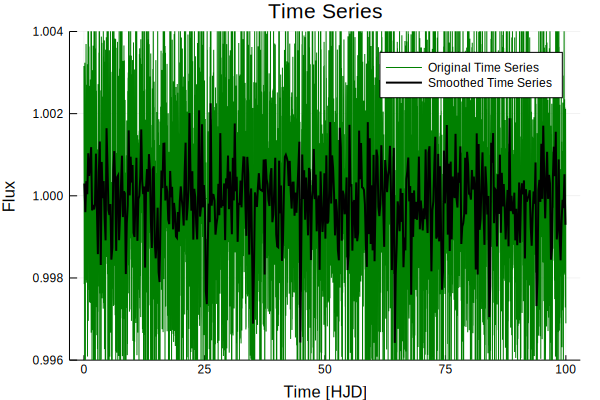

In [3]:
# Read in the data
mystery_planet02 = readdlm("mystery_planet02.txt")

# Extract the values for time, flux, and flux error
time = mystery_planet02[:,1]
flux = mystery_planet02[:,2]
error = mystery_planet02[:,3]

# Bin
time_smoothed = []
flux_smoothed = []
error_smoothed = []

n = 10
n_bins = convert(Int64, (length(time) - n) / n)

push!(time_smoothed, mean(time[1:n]))
push!(flux_smoothed, mean(flux[1:n]))
push!(error_smoothed, mean(flux[1:n]))

for i = 1:n_bins
    first = i * n + 1
    next = (first + n) - 1
    push!(time_smoothed, mean(time[first:next]))
    push!(flux_smoothed, mean(flux[first:next]))
    push!(error_smoothed, mean(flux[first:next]))
    
end

# Plot
plot(time, flux, label="Original Time Series", title="Time Series", 
    xlabel="Time [HJD]", ylabel="Flux [km/s]", seriescolor=:green, smooth = :true)
plot!(time_smoothed, flux_smoothed, label="Smoothed Time Series", 
    xlabel="Time [HJD]", ylabel="Flux", seriescolor=:black, lw = 2)
ylims!((0.996,1.004))

## Determine the period of the given planet

In [4]:
# Write a function to find the phase of the planet in its orbit over time
function FIND_PHASE(time, flux, period)
    phase = []
    calculated_phase = (time .- minimum(time)) ./ period
    phase = calculated_phase .- floor.(calculated_phase)

    return phase
end

FIND_PHASE (generic function with 1 method)

In [5]:
# Write a function to find the period of the planet's orbit
function P(time, flux)
    periods = []
    sum_point_distances = []
    
    for P = range(9.6, stop = 9.9, length=1000)
        push!(periods, P)
        phase = FIND_PHASE(time, flux, P)
        
        point_distances = []
        sorted_phase = sortperm(phase)
        
        for index in range(1, stop=length(sorted_phase)-1)

            point_distance = sqrt((phase[sorted_phase[index+1]] - phase[sorted_phase[index]])^2 
                + (flux[sorted_phase[index+1]] - flux[sorted_phase[index]])^2)
            push!(point_distances, point_distance)
        end
        push!(sum_point_distances, sum(point_distances))
    end
    
    index_of_interest = findall(sum_point_distances .== minimum(sum_point_distances))
    period = periods[index_of_interest]
    return period[1]
end

period = P(time_smoothed, flux_smoothed)

9.821021021021021

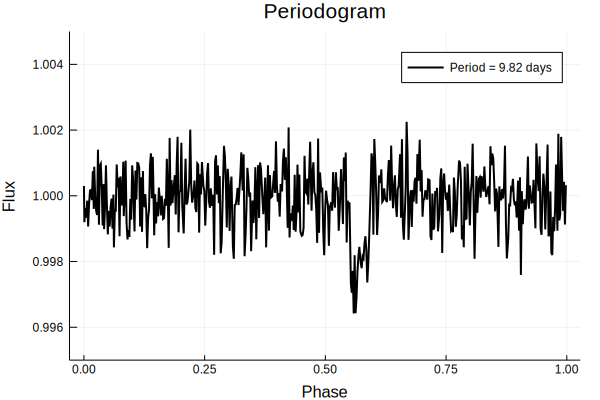

In [6]:
# Plot the folded smoothed light curve given the period found above
time = time_smoothed
flux = flux_smoothed
error = error_smoothed

phase = FIND_PHASE(time, flux, period)
sorted = sortperm(phase)

plot(phase[sorted], flux_smoothed[sorted], label=string("Period = ", round(period*100)/100, " days"), 
    title="Periodogram", xlabel="Phase", ylabel="Flux", seriescolor=:black, lw = 2)
ylims!((0.995,1.005))

## Model the transit of the planet *with* limb darkening

In [13]:
# Compute the separation between the planet and star, assuming a circular orbit
function SEPARATION(time, period, initial_phase, a, inclination)
    
    calculated_phase = time / period
    subtracted_phase = calculated_phase - floor(calculated_phase)
    calibrated_phase = subtracted_phase - initial_phase

    x = a * sin(calibrated_phase * 2 * pi)
    y = a * cos(calibrated_phase * 2 * pi) * cos(inclination)
    z = a * cos(calibrated_phase * 2 * pi) * sin(inclination)
    
    return x, y, z
end


# Compute the area of overlap between the planet and star
function A(r_star, r_p, x_separation, y, z)
    d = sqrt(x_separation.^2+y.^2)
    x = r_star
    
    if d <= r_p + x
        u = (d^2 + x^2 - r_p^2) / (2 * d * x)
        v = (d^2 + r_p^2 - x^2 ) / (2 * d * r_p)
        w = (-d + x + r_p) * (d + x - r_p) * (d - x + r_p) * (d + x + r_p)
    
        if (r_p - d) < x && x < r_p + d && z > 0
            A = ((x^2 * acos(u)) + (r_p^2 * acos(v)) - (0.5 * sqrt(w)))
        elseif x <= r_p - d && z > 0
            A = pi * x^2
        elseif x >= r_p + d && z > 0
            A = pi * r_p^2
        else
            A = 0.0
        end
    else
        A = 0.0
    end
    
    return A
end


# Compute fraction of flux blocked if the star is limb darkened
# Unused limb-darkening functions
function I_const(r)
    I0 = 1.0 / pi
    return I0
end

function I_linear(r)
    mu = sqrt(1 - r^2)
    c1 = 0.5
    I0 = (-3.0 / pi) * (c1 - 3.0)^(-1)
    I = I0 * (1 - c1 * (1 - mu))
    
    return I
end

# Used limb-darkening function
function I_quadratic(r, c1, c2)
    mu = sqrt(1 - r^2)
    I0 = (-6.0 / pi) * (2 * c1 + c2 - 6)^(-1)
    I = I0 * (1 - c1 * (1 - mu) - c2 * (1 - mu)^2)
    
    return I
end

function FRAC_FLUX_BLOCKED(I, r_star, r_p, x, y, z, c1, c2)
    
    delta = 0
    stellar_radial_coordinate_array = collect(range(0.0, stop = 1.0, step = 0.01))
    
    for i in range(2, stop = length(stellar_radial_coordinate_array), step = 1)
        
        delta += I(((stellar_radial_coordinate_array[i] + 
                stellar_radial_coordinate_array[i-1]) / 2), c1, c2) * 
                (A(stellar_radial_coordinate_array[i], r_p, x, y, z) - 
                A(stellar_radial_coordinate_array[i-1], r_p, x, y, z))
        
    end
    return delta
end

FRAC_FLUX_BLOCKED (generic function with 1 method)

## Apply the model with initial parameters

In [16]:
# Determine initial parameters
r_star = 1.0 # stellar radii
r_p = 0.05 # stellar radii
a = 8. # stellar radii
initial_phase = 0.58 # from phase-folded light curve
inclination = pi / 2 # edge on
c1 = 0.1
c2 = 0.1

# Write a function that computes the X^2
function COMPUTE_X2(data, error, model)
    X2 = sum((data .- model).^2 ./ error.^2)
    return X2
end

# Write a function that models the transit given the initial parameters above and returns the modeled flux
function MAKE_MODEL(params)
    period = P(time, flux)
    r_p, a, initial_phase, inclination, c1, c2 = params[1], params[2], params[3], params[4], params[5], params[6]

    x = [ x[1] for x in SEPARATION.(time, period, initial_phase, a, inclination) ]
    y = [ x[2] for x in SEPARATION.(time, period, initial_phase, a, inclination) ]
    z = [ x[3] for x in SEPARATION.(time, period, initial_phase, a, inclination) ]
    
    frac_flux_blocked_array = FRAC_FLUX_BLOCKED.(I_quadratic, 1.0, r_p, x, y, z, c1, c2)
    model = 1.0 .- frac_flux_blocked_array
    
    return model
end

# Write a function that computes the X^2 of the model and provides bounds for particular parameters
function MAKE_MODEL_return_X2(params)
    model = MAKE_MODEL(params)
    
    if c1 + c2 > 1.0 || r_p < 0.0
        X2 = 1e6
        return X2
    end

    X2 = COMPUTE_X2(flux, error, model)
    return X2
end

MAKE_MODEL_return_X2 (generic function with 1 method)

## Optimize parameters

In [17]:
# Make a model and return the X^2 given the initial parameters
initial_params = [r_p, a, initial_phase, inclination, c1, c2]
MAKE_MODEL_return_X2(initial_params)


# Use Optim to optimize parameters
result = optimize(MAKE_MODEL_return_X2, initial_params)
best_result = Optim.minimizer(result)


# Make a new model given the optimized parameters from Optim
MAKE_MODEL(best_result)

500-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

## Plot the resulting model

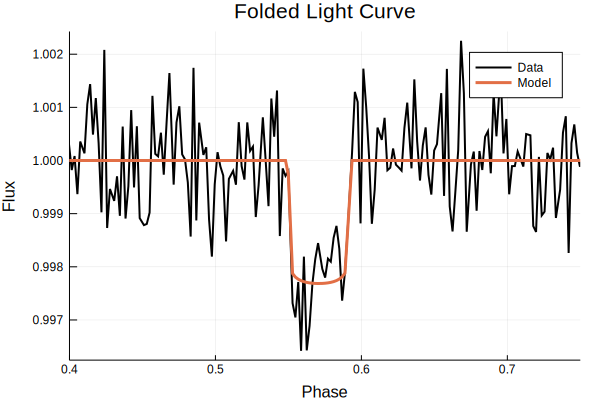

In [18]:
# Plot the unfolded time series
function PLOT_MODEL(params)
    model = MAKE_MODEL(params)

    plot(time, flux, label="Data",
        title="Light Curve", xlabel="Time", ylabel="Flux", seriescolor=:black, lw = 2)
    plot!(time, model, lw = 3, label = "Model")
end

# Plot the folded time series
function PLOT_FOLDED_MODEL(params)
    model = MAKE_MODEL(params)
    
    # Plot
    plot(phase[sorted], flux[sorted], label="Data",
        title="Folded Light Curve", xlabel="Phase", ylabel="Flux", seriescolor=:black, lw = 2)
    plot!(phase[sorted], model[sorted], lw = 3, label = "Model")
    xlims!(0.4, 0.75)
    
end

# Choose plot to display
# PLOT_MODEL(best_result)
PLOT_FOLDED_MODEL(best_result)

## Return the physical parameters resolved by the optimized model

In [19]:
# Call the optimized parameters from the model
# Planet radius, semi-major axis, initial phase, inclination
r_p, a, initial_phase, inclination = best_result[1], best_result[2], best_result[3], best_result[4]

# Derive additional physical parameters of the orbit
# Depth
model = MAKE_MODEL(best_result)
depth = 1.0 - minimum(model)

# Impact parameter
b = abs(a * cos(inclination))

# Transit duration
T = (period * (1.0 + r_p)) / (pi * a)
G = 4.982e-10 # km^3 / (kg  day^2)

# Stellar density
density = (3/pi^2) * (period / (G * T^3))# * (1 - b^2)^(3/2)

function round_value(value)
    n = 4
    factor = 10^n
    rounded_value = round(value * factor) / factor
    return rounded_value
end

println("Optimized Parameters:")
println("R_planet:         ", round_value(r_p), " * R_star")
println("Semi-major axis:  ", round_value(a), " * R_star")
println("Initial phase:    ", round_value(initial_phase))
println("Inclination:      ", round_value(inclination), " radians")

println(" ")
println("Modeled Parameters:")
println("Period:            ", round_value(period), " days")
println("Depth:             ", round_value(depth), " * R_star")
println("Impact Parameter:  ", round_value(b), " * R_star")
println("Duration:          ", round_value(T), " days")
println("Stellar Density:   ", density, " kg / km^3")

Optimized Parameters:
R_planet:         0.0469 * R_star
Semi-major axis:  7.8958 * R_star
Initial phase:    0.5799
Inclination:      1.577 radians
 
Modeled Parameters:
Period:            9.821 days
Depth:             0.0023 * R_star
Impact Parameter:  0.0491 * R_star
Duration:          0.4145 days
Stellar Density:   8.413964681681702e10 kg / km^3


## Acknowledgements

Many thanks to Eric Agol, Steven Stetzler, Debby Tran, Rudy Garcia, and Kathryn Neugent for aiding in comprehension of this assignment.